# Zipf-aware wave tokenization (word-level) quick viz

This notebook demo assigns per-token wave frequencies from word Zipf ranks (with per-query mixing), builds simple wave embeddings, and visualizes frequency bands and a toy attention superposition.

Steps:
1. Word-aware frequency assignment per query
2. Wave embedding preview (harmonic sin/cos)
3. Band/bucket view
4. Toy attention heatmap + entropy

Outputs are also saved as PNG under `figs/` for quick inspection.



In [1]:
import math
from pathlib import Path
from typing import List, Dict

import torch
import matplotlib.pyplot as plt
import numpy as np

# Self-contained word-aware frequency assigner (no external import)
from dataclasses import dataclass
from collections import Counter

@dataclass
class WordFreqConfig:
    vocab_size_words: int
    freq_min: float = 0.0
    freq_max: float = 1.0
    mix_weight: float = 0.7  # weight on global rank vs local rank

    def validate(self) -> bool:
        assert self.vocab_size_words > 0, "vocab_size_words must be positive"
        assert 0.0 <= self.freq_min < self.freq_max <= 1.0, "freq_min/freq_max must satisfy 0 <= min < max <= 1"
        assert 0.0 <= self.mix_weight <= 1.0, "mix_weight must be in [0,1]"
        return True

class WordFrequencyAssigner:
    def __init__(self, tokenizer, word_rank_table: Dict[str, int], config: WordFreqConfig) -> None:
        self.tokenizer = tokenizer
        self.word_rank_table = word_rank_table
        self.config = config
        self.config.validate()

    def _word_ranks(self, words: List[str]) -> List[int]:
        default_rank = self.config.vocab_size_words  # rarest fallback
        return [self.word_rank_table.get(w, default_rank) for w in words]

    def _local_ranks(self, words: List[str]) -> List[int]:
        counts = Counter(words)
        sorted_words = sorted(counts.items(), key=lambda x: (-x[1], x[0]))
        local_rank_map = {w: i for i, (w, _) in enumerate(sorted_words, start=1)}
        return [local_rank_map[w] for w in words]

    def _mix_ranks(self, global_rank: int, local_rank: int) -> float:
        a = self.config.mix_weight
        return (global_rank ** a) * (local_rank ** (1.0 - a))

    def _rank_to_freq(self, rank: torch.Tensor) -> torch.Tensor:
        log_v = torch.log(torch.tensor(float(self.config.vocab_size_words)))
        norm = torch.log(rank) / log_v
        return self.config.freq_min + (self.config.freq_max - self.config.freq_min) * norm

    def assign(self, text: str):
        encoded = self.tokenizer.encode_plus(text, return_offsets_mapping=True, add_special_tokens=False)
        token_ids = torch.tensor(encoded["input_ids"], dtype=torch.long)
        offsets = encoded["offset_mapping"]
        words: List[str] = []
        token_to_word: List[int] = []
        prev_end = -1
        word_idx = -1
        for (start, end) in offsets:
            if start == prev_end:
                token_to_word.append(word_idx)
            else:
                word_idx += 1
                token_to_word.append(word_idx)
                words.append(text[start:end])
            prev_end = end
        global_ranks = self._word_ranks(words)
        local_ranks = self._local_ranks(words)
        eff_ranks = [self._mix_ranks(g, l) for g, l in zip(global_ranks, local_ranks)]
        rank_tensor = torch.tensor([eff_ranks[idx] for idx in token_to_word], dtype=torch.float32)
        freqs = self._rank_to_freq(rank_tensor)
        return token_ids, freqs

# Figure directory
NOTEBOOK_DIR = Path.cwd()
FIG_DIR = NOTEBOOK_DIR / "figs"
FIG_DIR.mkdir(exist_ok=True)

# Lightweight whitespace tokenizer with offsets compatible with WordFrequencyAssigner expectations
class WhiteSpaceTokenizer:
    def encode_plus(self, text: str, return_offsets_mapping=True, add_special_tokens=False):
        words = text.split()
        offsets = []
        input_ids = []
        pos = 0
        for w in words:
            start = text.find(w, pos)
            end = start + len(w)
            offsets.append((start, end))
            input_ids.append(hash(w) % 10000)  # fake token id
            pos = end
        return {"input_ids": input_ids, "offset_mapping": offsets}

# Example text and word rank table (mock Zipf ranks; 1 = most common)
text = "the quick brown fox jumps over the lazy dog the fox"
word_ranks: Dict[str, int] = {
    "the": 1,
    "over": 50,
    "quick": 500,
    "brown": 1200,
    "fox": 900,
    "jumps": 1500,
    "lazy": 2500,
    "dog": 1800,
}

config = WordFreqConfig(vocab_size_words=30000, freq_min=0.0, freq_max=1.0, mix_weight=0.7)
tokenizer = WhiteSpaceTokenizer()
assigner = WordFrequencyAssigner(tokenizer, word_ranks, config)

token_ids, freqs = assigner.assign(text)
positions = torch.arange(len(token_ids), dtype=torch.float32)

print("Tokens:", token_ids.tolist())
print("Freqs:", freqs.tolist())



Tokens: [989, 8967, 2151, 7609, 3488, 3866, 989, 9059, 6949, 989, 7609]
Freqs: [0.0, 0.4824989140033722, 0.5134020447731018, 0.4820684492588043, 0.5434194803237915, 0.3222625255584717, 0.0, 0.5834113359451294, 0.5493058562278748, 0.0, 0.4820684492588043]


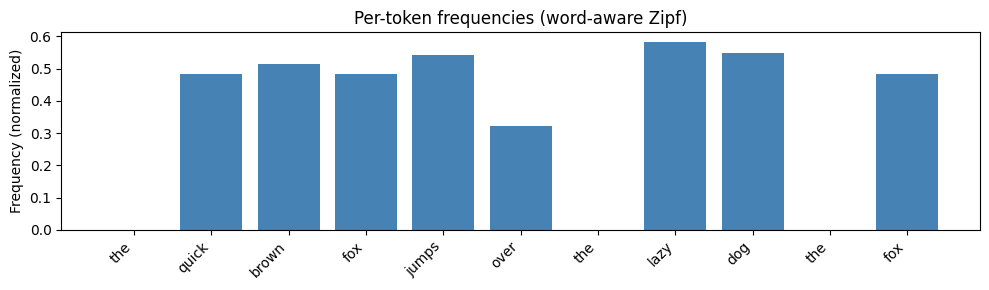

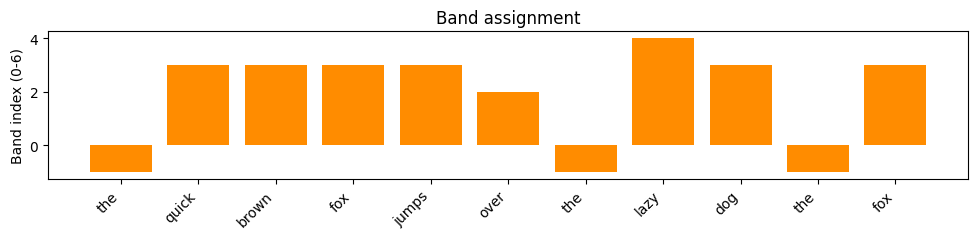

In [2]:
# Band assignment and frequency plot
words = text.split()
num_bands = 7
band_edges = torch.linspace(config.freq_min, config.freq_max, num_bands + 1)
band_ids = torch.bucketize(freqs, band_edges) - 1  # 0-based

plt.figure(figsize=(10, 3))
plt.bar(range(len(freqs)), freqs.numpy(), color="steelblue")
plt.xticks(range(len(freqs)), words, rotation=45, ha="right")
plt.ylabel("Frequency (normalized)")
plt.title("Per-token frequencies (word-aware Zipf)")
plt.tight_layout()
plt.savefig(FIG_DIR / "freqs.png", dpi=150)
plt.show()

plt.figure(figsize=(10, 2.5))
plt.bar(range(len(band_ids)), band_ids.numpy(), color="darkorange")
plt.xticks(range(len(freqs)), words, rotation=45, ha="right")
plt.ylabel("Band index (0-6)")
plt.title("Band assignment")
plt.tight_layout()
plt.savefig(FIG_DIR / "bands.png", dpi=150)
plt.show()



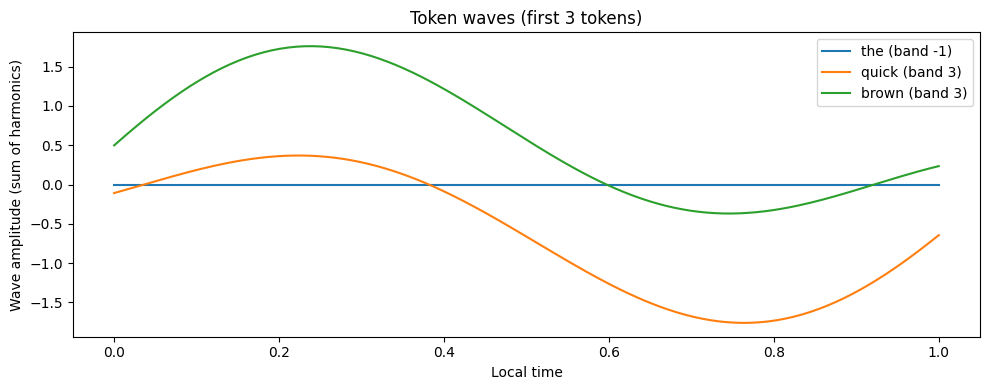

In [3]:
# Wave embedding preview (simple sin/cos, 2 harmonics)
harmonics = torch.arange(1, 3, dtype=torch.float32)

t_local = torch.linspace(0, 1, 200)
plt.figure(figsize=(10, 4))
for i in range(min(3, len(freqs))):
    f = freqs[i]
    p = positions[i]
    wave = 0
    for h in harmonics:
        wave = wave + torch.sin(2 * math.pi * f * h * (p + t_local))
    plt.plot(t_local.numpy(), wave.numpy(), label=f"{words[i]} (band {band_ids[i].item()})")
plt.xlabel("Local time")
plt.ylabel("Wave amplitude (sum of harmonics)")
plt.title("Token waves (first 3 tokens)")
plt.legend()
plt.tight_layout()
plt.savefig(FIG_DIR / "waves.png", dpi=150)
plt.show()



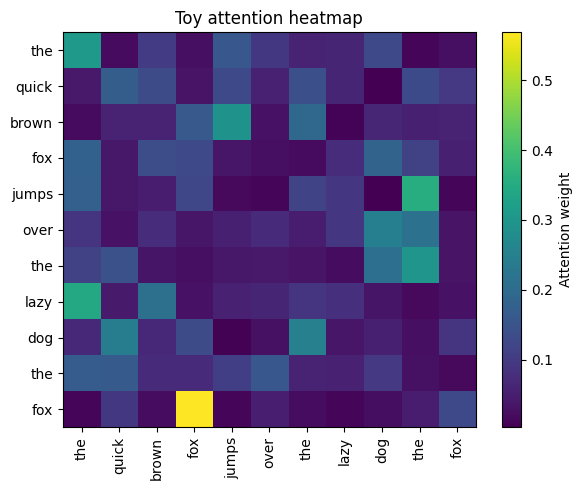

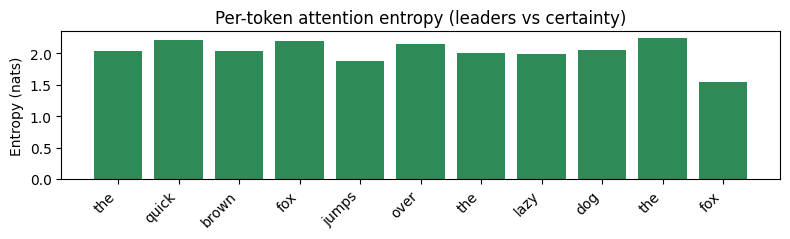

In [4]:
# Toy attention superposition and entropy
seq_len = len(freqs)
logits = torch.randn(seq_len, seq_len)
attn = torch.softmax(logits, dim=-1)

entropy = -(attn * (attn.clamp(min=1e-9).log())).sum(dim=-1)

plt.figure(figsize=(6, 5))
plt.imshow(attn.numpy(), cmap="viridis", aspect="auto")
plt.colorbar(label="Attention weight")
plt.xticks(range(seq_len), words, rotation=90)
plt.yticks(range(seq_len), words)
plt.title("Toy attention heatmap")
plt.tight_layout()
plt.savefig(FIG_DIR / "attention_heatmap.png", dpi=150)
plt.show()

plt.figure(figsize=(8, 2.5))
plt.bar(range(seq_len), entropy.numpy(), color="seagreen")
plt.xticks(range(seq_len), words, rotation=45, ha="right")
plt.ylabel("Entropy (nats)")
plt.title("Per-token attention entropy (leaders vs certainty)")
plt.tight_layout()
plt.savefig(FIG_DIR / "attention_entropy.png", dpi=150)
plt.show()

